<a href="https://colab.research.google.com/github/zhenchenZ/test/blob/main/attention_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


# Self-attention layer (simplified)

In [ ]:
class SimpleAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"

        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # Linear layer producing q, k, v at once
        self.qkv = nn.Linear(dim, 3 * dim, bias=True)

    def forward(self, x, return_attn: bool = False):
        """x: (B, T, dim)"""
        B, T, C = x.shape
        qkv = self.qkv(x)  # (B, T, 3*dim)
        qkv = qkv.reshape(B, T, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.unbind(dim=2)  # each: (B, T, num_heads, head_dim)

        # (B, num_heads, T, head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Attention scores: (B, num_heads, T, T)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        # Weighted sum of values: (B, num_heads, T, head_dim)
        y = attn @ v

        # Merge heads: (B, T, C)
        y = y.transpose(1, 2).reshape(B, T, C)

        if return_attn:
            return y, attn
        return y


In [ ]:
# Example instantiation (you can change dim / num_heads if needed)
dim = 8
num_heads = 2
model = SimpleAttention(dim, num_heads=num_heads).to(device)
print("attention layer instantiated")

attention layer instantiated


## Question 1 – Parameter count

1. Compute the theoretical number of parameters of the model
2. Using PyTorch, compute the actual number of parameters in `model` to check the theoretical value


In [ ]:
# Q1 – TODO: compute and print the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters in SimpleAttention:", total_params)

# You can also inspect only the qkv layer:
print("qkv weight shape:", model.qkv.weight.shape)
print("qkv bias shape:  ", model.qkv.bias.shape)

Total parameters in SimpleAttention: 216
qkv weight shape: torch.Size([24, 8])
qkv bias shape:   torch.Size([24])


## Question 2 – Attention map of a single head

Consider a toy input with `B = 1`, `T = 4`, `C = 8`.

1. Create a random input `x` of shape `(1, 4, 8)` and run a forward pass with `return_attn=True`.
2. Extract the attention matrix of **head_0** (of index `0`) into a variable named `attn_weight`
3. Plot this matrix as a heatmap. You can use the function `sns.heatmap(attn_weight, annot=True, cmap="viridis", square=True)`
4. Explain what a large value at position `(i, j)` means


y shape: torch.Size([1, 4, 8])
attn shape: torch.Size([1, 2, 4, 4])


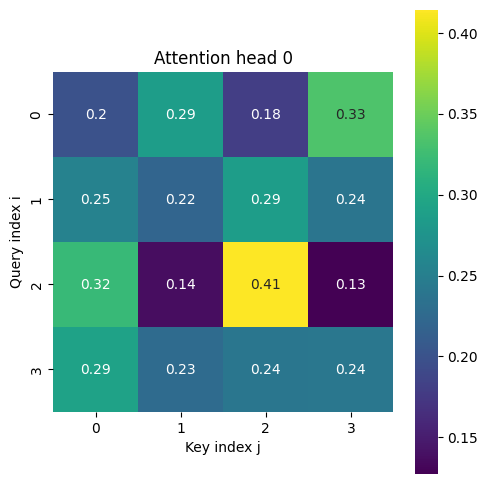

In [ ]:
# Q2 – TODO: compute and visualize one head's attention map
B, T, C = 1, 4, 8
torch.manual_seed(0)

x = torch.randn(B, T, C, device=device)
y, attn = model(x, return_attn=True)

print("y shape:", y.shape)          # (1, 4, 64) if dim=64
print("attn shape:", attn.shape)    # (1, num_heads, 4, 4)

# Example: select head 0
head_idx = 0
attn_weight = attn[0, head_idx].detach().cpu().numpy()

plt.figure(figsize=(5, 5))
sns.heatmap(attn_weight, annot=True, cmap="viridis", square=True)
plt.title(f"Attention head {head_idx}")
plt.xlabel("Key index j")
plt.ylabel("Query index i")
plt.tight_layout()
plt.show()

## Question 3 – Gradient sanity check

We want to inspect gradient magnitudes through the attention block.

1. Create a random input `x` with shape `(B, T, C)` (for example `B = 8`, `T = 16`, `C = 8`) and set `requires_grad=True`.
2. Run a forward pass `y = model(x)` and define a fake scalar loss:
   ```python
   fake_loss = (y ** 2).sum()
   ```
3. Compute the gradients of all parameters w.r.t. the fake loss and examine their values: do they look healthy, exploding, or vanishing?  
4. Briefly list common remedies for unstable gradients (e.g., exploding or vanishing).


Parameter: qkv.weight
  Grad min: -21.977779
  Grad max: 11.568295
  Grad mean abs: 2.828075


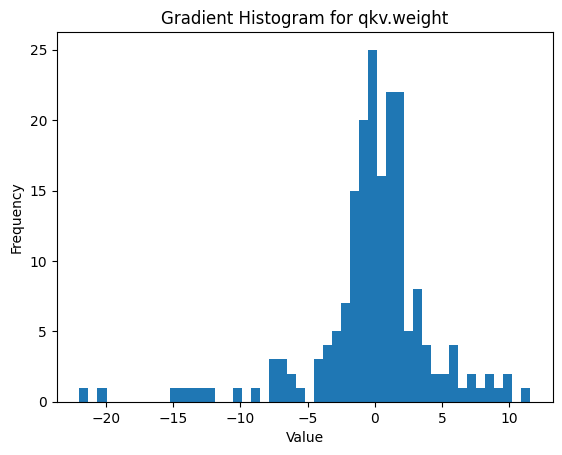

Parameter: qkv.bias
  Grad min: -62.466290
  Grad max: 29.566353
  Grad mean abs: 9.708178


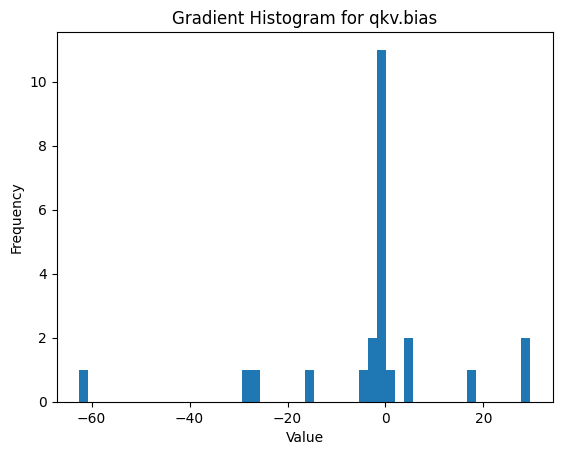

In [ ]:
# Q3 – TODO: compute and inspect gradients
B, T, C = 8, 16, 8
x = torch.randn(B, T, C, device=device, requires_grad=True)

model.zero_grad()
y = model(x)
fake_loss = (y ** 2).sum()
fake_loss.backward()

def plot_hist(torch_tensor, title):
	tensor_cpu = torch_tensor.detach().cpu().view(-1)
	plt.figure()
	plt.hist(tensor_cpu.numpy(), bins=50)
	plt.title(title)
	plt.xlabel("Value")
	plt.ylabel("Frequency")
	plt.show()

for name, param in model.named_parameters():
	if param.grad is not None:
		grad = param.grad
		print(f"Parameter: {name}")
		print(f"  Grad min: {grad.min().item():.6f}")
		print(f"  Grad max: {grad.max().item():.6f}")
		print(f"  Grad mean abs: {grad.abs().mean().item():.6f}")
		plot_hist(grad, f"Gradient Histogram for {name}")
	else:
		print(f"Parameter: {name} has no gradient.")

torch.Size([24])